## Importing Dependencies

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from missingpy import MissForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
X = pd.read_csv('train_x.csv')
X.drop(['ID'], axis=1, inplace=True)

y = pd.read_csv('train_y.csv')
y.drop(['ID'], axis=1, inplace=True)

X.head()

Expense       Income Loan type Occupation type  Age    Score1  \
0  1830.943788  14767.28013         B               Y  1.0  0.016885   
1  1645.302546  15272.26775         B               Y  0.0  0.240375   
2  1555.026392  17482.49734         A               Y  0.0  0.213921   
3          NaN  16257.66493         A               Y  0.0  0.303909   
4  1777.648916  16316.29914         B               X  1.0       NaN   

       Score2     Score3      Score4       Score5  
0  205.196182  22.521523  600.911200  3464.613291  
1  194.266317   5.349117  600.888816  3374.921455  
2  183.529871  -1.054954  598.596944  3331.304886  
3  191.228965   6.971750  602.447203  3392.275849  
4  224.074728  11.218489  605.947340  3438.864083

## Label Encoding

In [3]:
# converting characters to numeric variables
X['Loan type'][X['Loan type'] == 'A'] = 0
X['Loan type'][X['Loan type'] == 'B'] = 1

X['Occupation type'][X['Occupation type'] == 'X'] = 0
X['Occupation type'][X['Occupation type'] == 'Y'] = 1
X['Occupation type'][X['Occupation type'] == 'Z'] = 2

X = X.astype(float)

X.head()

Expense       Income  Loan type  Occupation type  Age    Score1  \
0  1830.943788  14767.28013        1.0              1.0  1.0  0.016885   
1  1645.302546  15272.26775        1.0              1.0  0.0  0.240375   
2  1555.026392  17482.49734        0.0              1.0  0.0  0.213921   
3          NaN  16257.66493        0.0              1.0  0.0  0.303909   
4  1777.648916  16316.29914        1.0              0.0  1.0       NaN   

       Score2     Score3      Score4       Score5  
0  205.196182  22.521523  600.911200  3464.613291  
1  194.266317   5.349117  600.888816  3374.921455  
2  183.529871  -1.054954  598.596944  3331.304886  
3  191.228965   6.971750  602.447203  3392.275849  
4  224.074728  11.218489  605.947340  3438.864083

## MissForest Imputation

In [4]:
imputer = MissForest(class_weight='balanced')
imputer.fit(X, y, cat_vars=[2, 3, 4])
X_imp = pd.DataFrame(imputer.transform(X), columns=X.columns)

# setting dtype as int for categorical variables
X_imp = X_imp.astype({'Loan type':int, 'Occupation type':int, 'Age':int})

X_imp.info()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Expense          80000 non-null  float64
 1   Income           80000 non-null  float64
 2   Loan type        80000 non-null  int32  
 3   Occupation type  80000 non-null  int32  
 4   Age              80000 non-null  int32  
 5   Score1           80000 non-null  float64
 6   Score2           80000 non-null  float64
 7   Score3           80000 non-null  float64
 8   Score4           80000 non-null  float64
 9   Score5           80000 non-null  float64
dtypes: float64(7), int32(3)
memory usage: 5.2 MB


In [8]:
# dropping samples with missing labels
X_ = X_imp[~np.isnan(y['Label'])]
y_ = (y['Label'][~np.isnan(y['Label'])]).astype(int)
X_miss = X_imp[np.isnan(y['Label'])]

## Model Selection

[17:07:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


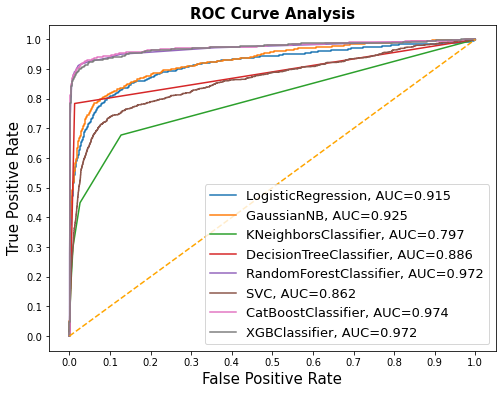

In [11]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(), 
               GaussianNB(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               SVC(probability=True), 
               CatBoostClassifier(verbose=False), 
               XGBClassifier()]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

# Plot
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## Training

In [21]:
# grid search for hyperparameter tuning
model = CatBoostClassifier(class_weights=[1, 14], eval_metric='F1')
grid = {'learning_rate': [0.01, 0.03, 0.1, 0.3],
        'depth': [4, 6, 8, 10, 15, 20],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9262466143
bestIteration = 902


bestTest = 0.932877867
bestIteration = 991


bestTest = 0.9347778023
bestIteration = 273


bestTest = 0.9332094011
bestIteration = 111


bestTest = 0.9254553532
bestIteration = 998


bestTest = 0.9360573096
bestIteration = 995


bestTest = 0.9364797729
bestIteration = 576


bestTest = 0.9341169193
bestIteration = 102


bestTest = 0.9268314328
bestIteration = 872


bestTest = 0.9320491767
bestIteration = 996


bestTest = 0.9360987043
bestIteration = 294


bestTest = 0.9353154588
bestIteration = 122


bestTest = 0.9255375866
bestIteration = 964


bestTest = 0.9339121191
bestIteration = 964


bestTest = 0.9358570859
bestIteration = 390


bestTest = 0.933624182
bestIteration = 234


bestTest = 0.9259078181
bestIteration = 993


bestTest = 0.9366741792
bestIteration = 992


bestTest = 0.9361363837
bestIteration = 280


bestTest = 0.9366830608
bestIteration = 149


bestTest = 0.9358123063
bestIteration = 991


bestTest = 0.9373529281
bestIterati

KeyboardInterrupt: 

In [41]:
model = CatBoostClassifier(depth=6, l2_leaf_reg=1, learning_rate=0.1, class_weights=[1, 14], eval_metric='F1', verbose=False)
dtrain = Pool(data=X_, label=y_, cat_features=['Loan type', 'Occupation type', 'Age'])
model.fit(dtrain)

# using the learned model to predict missing labels in the training data
y_miss = model.predict(X_miss)
y_prob = model.predict(X_miss, prediction_type='Probability')

# discarding samples predicted with < 0.95 probability and using the others for re-training the model
y_max = np.max(y_prob, axis=1)
X_new = X_miss[y_max > 0.95]
y_new = y_miss[y_max > 0.95]
print("Fraction of samples discarded:", (len(y_max[y_max<0.95]) / len(X)))

Fraction of samples discarded: 0.007482046847388803


In [45]:
X = pd.concat([X_, X_new], axis=0)
y = pd.concat([y_, pd.DataFrame(y_new)], axis=0).astype(int)

dtrain = Pool(data=X, label=y, cat_features=['Loan type', 'Occupation type', 'Age'])
model.fit(dtrain)

## Feature Importance

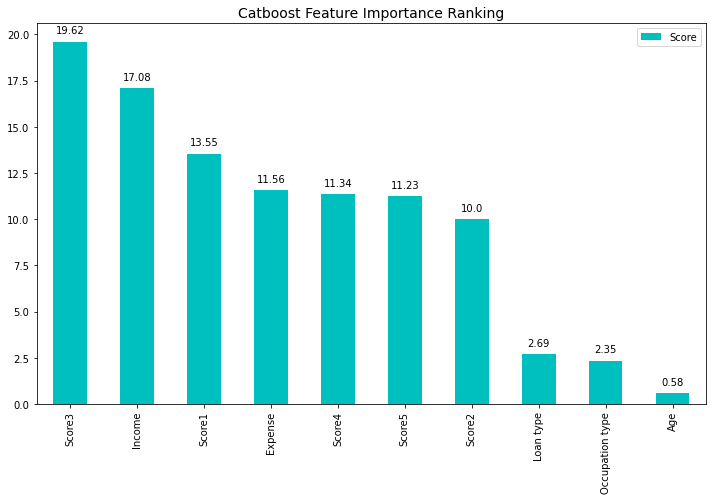

In [46]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance())), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

## Predictions

In [47]:
X_test= pd.read_csv('test_X.csv')
X_test.drop(['ID_Test'], axis=1, inplace=True)

X_test['Loan type'][X_test['Loan type'] == 'A'] = 0
X_test['Loan type'][X_test['Loan type'] == 'B'] = 1

X_test['Occupation type'][X_test['Occupation type'] == 'X'] = 0
X_test['Occupation type'][X_test['Occupation type'] == 'Y'] = 1
X_test['Occupation type'][X_test['Occupation type'] == 'Z'] = 2

X_test = X_test.astype({'Loan type':int, 'Occupation type':int, 'Age':int})

In [48]:
y_pred = model.predict(X_test)
y_fin = pd.concat([pd.DataFrame(np.arange(1, 20001, dtype=int), columns=['ID_Test']),
                   pd.DataFrame(y_pred, columns=['Label'])], axis=1)
y_fin.head()

ID_Test  Label
0        1      0
1        2      0
2        3      0
3        4      0
4        5      0

In [49]:
# saving to csv
# pd.DataFrame(y_fin).to_csv('submissions/pred_y.csv', header=y_fin.columns, index=None)